# [DIS 3] ReLUs and Neural Network Intuition with different Optimizers

**If you are running on a local anaconda install, you will need to install pytorch with the command**
```sh
conda install pytorch -c pytorch
```

<!-- #TODO(krishna) : add wandb integration -->
<!-- You should immediately run all the cells up through 'Train all layers' since training the networks takes a long time. While you wait you can return to the theory portion of this discussion and work on the backpropagation problem. -->

In [ ]:
#@title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title Set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs182fa23_public'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182fa23_public'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("cs182fa23_public"):
  !git clone https://github.com/Berkeley-CS182/cs182fa23_public.git
%cd cs182fa23_public
!git pull
%cd dis/dis03/code

In [9]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import sys
from ipywidgets import fixed, interactive, widgets 
from tqdm import tqdm

from helpers import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Training and Test Data

We are using piecewise linear function. Our training data has added noise $y = f(x) + \epsilon,\, \epsilon \sim \mathcal{N}(0, \sigma^2)$. The test data is noise free.

_After you have gone through the discussion, you may wish to adjust the number of training samples and noise variance to see how gradient descent behaves under the new conditions._

In [2]:
f_type = 'piecewise_linear'

def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX)) 
    
n_features = 1
n_samples = 200
sigma = 0.01
rng = np.random.RandomState(1)

# Generate train data
X = np.sort(rng.rand(n_samples, n_features), axis=0)
y = f_true(X, f_type) + rng.randn(n_samples) * sigma

# Generate NOISELESS test data
X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
X_test = np.sort(X_test, axis=0)
y_test = f_true(X_test, f_type)

# Save checkpoint files
DIR_SGD = os.path.join(os.getcwd(), 'ckpts/sgd')
DIR_SGDM = os.path.join(os.getcwd(), 'ckpts/sgd_momentum')
DIR_ADAM = os.path.join(os.getcwd(), 'ckpts/adam')
os.makedirs(DIR_SGD, exist_ok=True)
os.makedirs(DIR_SGDM, exist_ok=True)
os.makedirs(DIR_ADAM, exist_ok=True)

def get_ckpt_dir(optim: str):
    if optim == 'sgd':
        return DIR_SGD
    elif optim == 'sgd_momentum':
        return DIR_SGDM
    elif optim == 'adam':
        return DIR_ADAM
    else:
        raise NotImplementedError


# Define the Neural Networks

We will learn the piecewise linear target function using a simple 1-hidden layer neural network with ReLU non-linearity, defined by
$$ \hat{y} = \mathbf{W}^{(2)} \Phi \left( \mathbf{W}^{(1)} x + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)} $$
where $\Phi(x) = ReLU(x)$ and superscripts refer to indices, not the power operator.

We will also create two SGD optimizers to allow us to choose whether to train all parameters or only the linear output layer's parameters. Note that we use separate learning rates for the two version of training. There is too much variance in the gradients when training all layers to use a large learning rate, so we have to decrease it.

We will modify the default initialization of the biases so that the ReLU elbows are all inside the region we are interested in.

We create several versions of this network with varying widths to explore how hidden layer width impacts learning performance.

_Once you have gone through the discussion once you may wish to train networks with even larger widths to see how they behave under the three different training paradigms in this notebook._

In [3]:
# Don't rerun this cell after training or you will lose all your work
nets_by_size = {}
nn_widths = [10, 20, 40]
nn_optimizer = ['sgd', "sgd_momentum", 'adam']
nn_seeds = [
  442, 370, 378, 892, 836, 209, 327, 316, 216, 308,
  748, 934, 558, 546, 266, 808, 884, 818, 277, 979, 
  766, 274, 479, 325, 431, 971, 689, 871, 272, 704
]

def setup_networks(widths, optimizer, seed):
  
  torch.manual_seed(seed)
  nets_by_size[seed] = dict()

  for width in widths:

      nets_by_size[seed][width] = dict()
      # Define a 1-hidden layer ReLU nonlinearity network. 
      # Initialize outside the optimizer loop to keep weight init the same.
      net = nn.Sequential(
        nn.Linear(1, width),
        nn.ReLU(),
        nn.Linear(width, 1)
      )

      for optim in optimizer:
        
        # Clone the network
        network = copy.deepcopy(net)

        # Get trainable parameters
        weights_all = list(network.parameters())
        
        # Get the output weights alone
        weights_out = weights_all[2:]
        # Adjust initial biases so elbows are in [0,1]
        elbows = np.sort(np.random.rand(width)) 
        new_biases = -elbows * to_numpy(weights_all[0].cpu()).ravel()
        weights_all[1].data = to_torch(new_biases)
        # Create SGD optimizers for outputs alone and for all weights
        # lr_out = 0.2
        lr_all = 0.02
        if optim == 'sgd':
          opt_all = torch.optim.SGD(params=weights_all, lr=lr_all)
        elif optim == 'sgd_momentum':
          opt_all = torch.optim.SGD(params=weights_all, lr=lr_all, momentum=0.9)
        elif optim == 'adam':
          opt_all = torch.optim.Adam(params=weights_all, lr=lr_all )
        # opt_out = torch.optim.SGD(params=weights_out, lr=lr_out)
        nets_by_size[seed][width][optim] = {
          'net': network,
          'opt_all': opt_all,
          'optim': optim,
          'seed': seed
        }

for s in nn_seeds:
  setup_networks(nn_widths, nn_optimizer, s)

# Train all the networks now - this will take a while!
You can expect training to take between 5 and 10 minutes depending on whether you run locally or on Google Colab.

In [30]:
n_steps = 30000
save_every = 3000 #1000
t0 = time.time()

def train_all_seeds(widths, optims, seeds):
  
    for w in widths:
      for i, optim in enumerate(optims):

        print("-"*40)
        print("Width", w, "Optimizer", optim)
        list_of_history = []

        print(f"training with {len(seeds)} seeds...")
        for seed in tqdm(seeds):
          net = nets_by_size[seed][w][optim]['net']
          opt_all = nets_by_size[seed][w][optim]['opt_all']

          save_dir = f'{get_ckpt_dir(optim)}/width{w}/seed{seed}/'
          os.makedirs(save_dir, exist_ok=True)

          history_all = train_network(X, y, X_test, y_test, 
                                  net, optim=opt_all, 
                                  n_steps=n_steps, save_every=save_every, 
                                  verbose=False, optimizer=optim, seed=seed,
                                  ckpt_dir=save_dir)
          nets_by_size[seed][w][optim]['hist_all'] = history_all
          list_of_history.append(history_all)  
      
train_all_seeds(widths=nn_widths, optims=nn_optimizer, seeds=nn_seeds)
  
t1 = time.time()
print("-"*40)
print("Trained all layers in %.1f minutes" % ((t1 - t0) / 60))

# Compile the tensors into a dictionary
data_dict = {
    'X': X,
    'y': y,
    'X_test': X_test,
    'y_test': y_test
}

# Define a file path to save the data
file_path = 'ckpts/tensors.pth'

# Save the data to a file
torch.save(data_dict, file_path)

----------------------------------------
Width 10 Optimizer sgd
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [02:58<00:00,  5.94s/it]


----------------------------------------
Width 10 Optimizer sgd_momentum
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [03:21<00:00,  6.73s/it]


----------------------------------------
Width 10 Optimizer adam
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [04:44<00:00,  9.48s/it]


----------------------------------------
Width 20 Optimizer sgd
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [03:20<00:00,  6.69s/it]


----------------------------------------
Width 20 Optimizer sgd_momentum
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [03:24<00:00,  6.82s/it]


----------------------------------------
Width 20 Optimizer adam
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [04:33<00:00,  9.11s/it]


----------------------------------------
Width 40 Optimizer sgd
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [02:56<00:00,  5.88s/it]


----------------------------------------
Width 40 Optimizer sgd_momentum
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [03:51<00:00,  7.70s/it]


----------------------------------------
Width 40 Optimizer adam
training with 30 seeds...


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [04:30<00:00,  9.00s/it]

----------------------------------------
Trained all layers in 33.7 minutes


In [36]:
# Load the data from the file
loaded_data_dict = torch.load("ckpts/tensors.pth")

# Unpack the loaded data
X = loaded_data_dict['X']
y = loaded_data_dict['y']
X_test = loaded_data_dict['X_test']
y_test = loaded_data_dict['y_test']

## Plot Training Losses

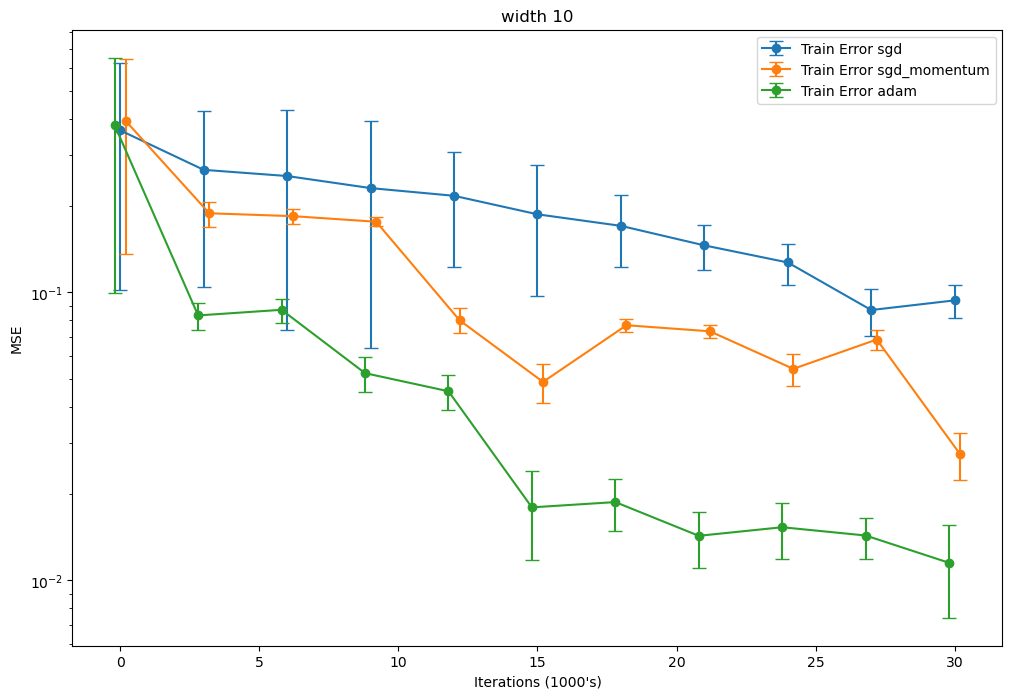

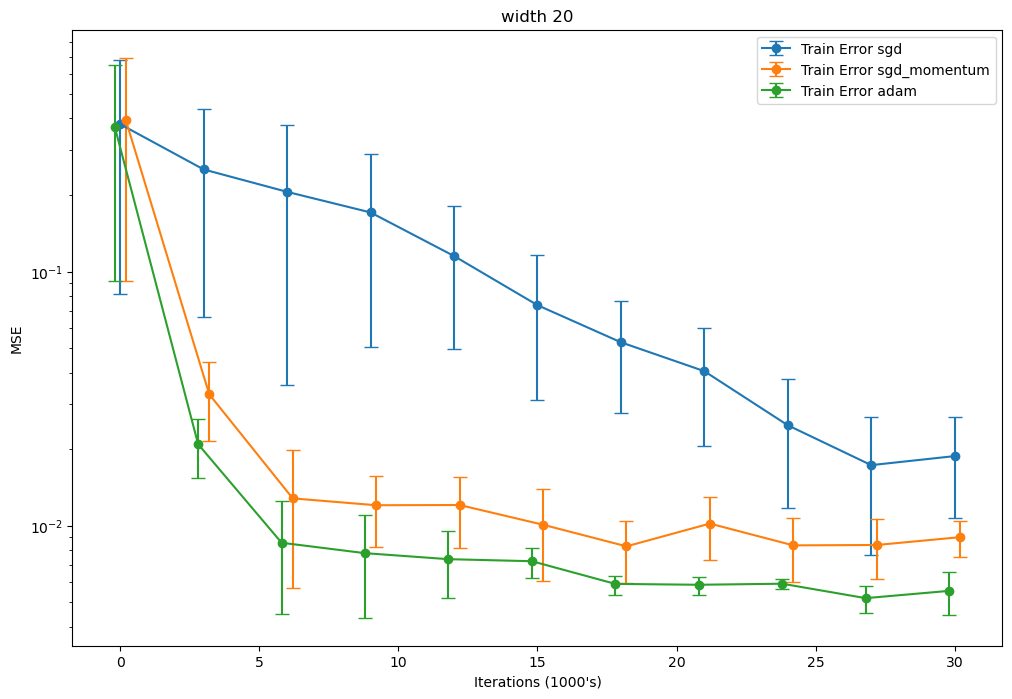

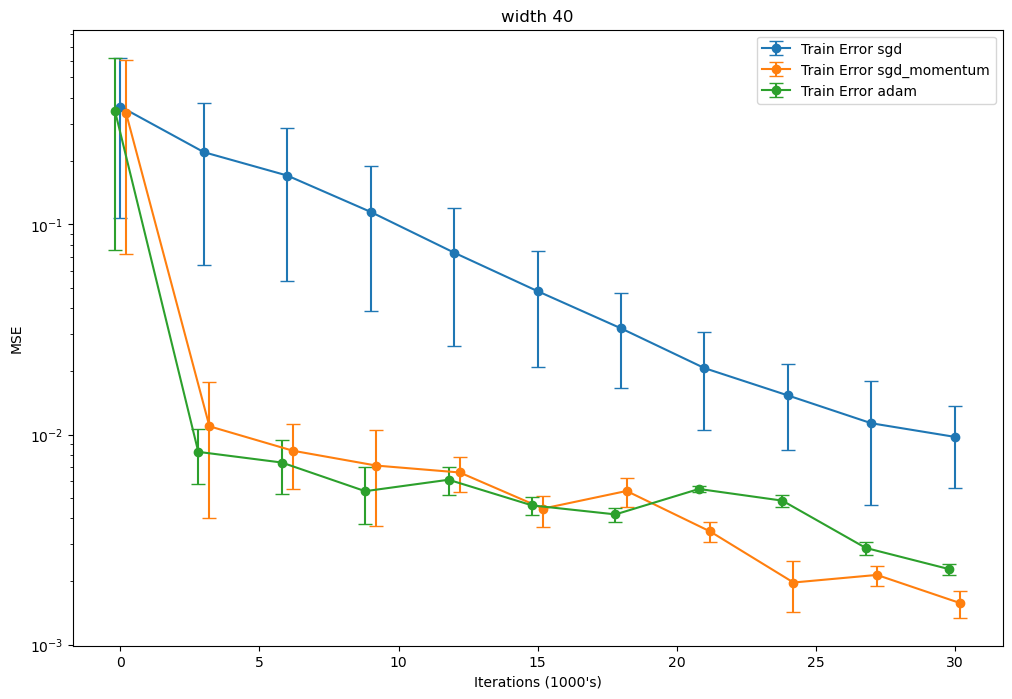

In [33]:
for w in nn_widths:
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, optim in enumerate(nn_optimizer):
        
        # uncomment below if you ran the previous block to train all models
        # list_of_history = [nets_by_size[s][w][optim]['hist_all'] for s in nn_seeds]
        
        # uncomment below if you want to use pretrained weights
        c = get_ckpt_dir(optim)
        list_of_history = [
            torch.load(
                os.path.join(f'{get_ckpt_dir(optim)}/width{w}/seed{s}', 'ckpt_and_history.pt')
            ) for s in nn_seeds
        ]
        plot_with_error_bar(list_of_history, optim=optim, plot_train=True, idx=i, ax=ax)
    ax.set_title(f"width {w}")
    plt.show()

## Plot Test Losses

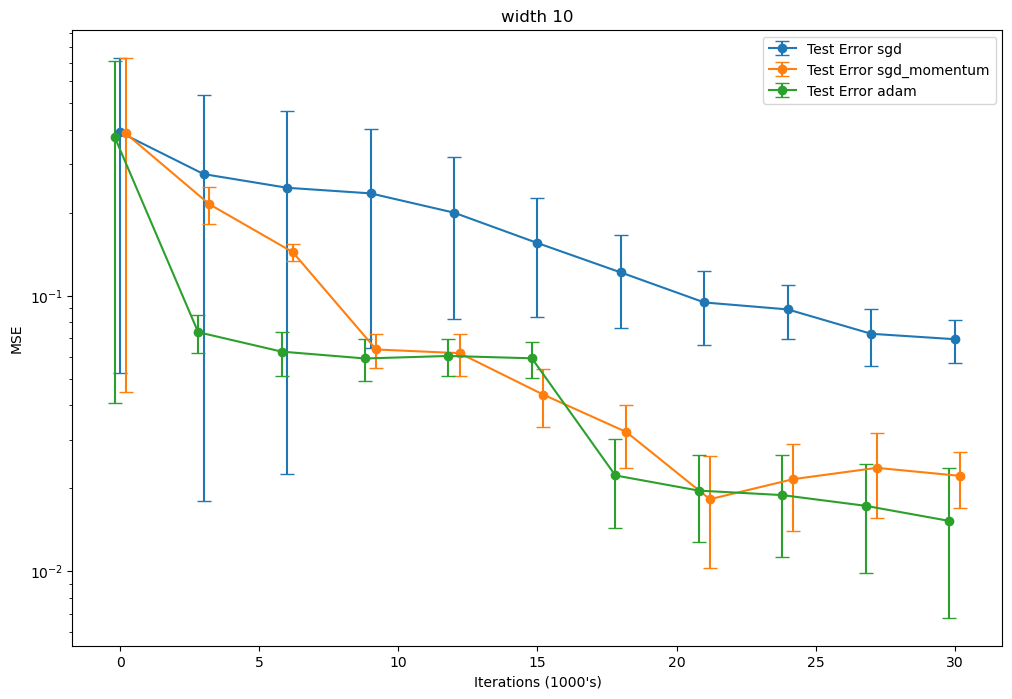

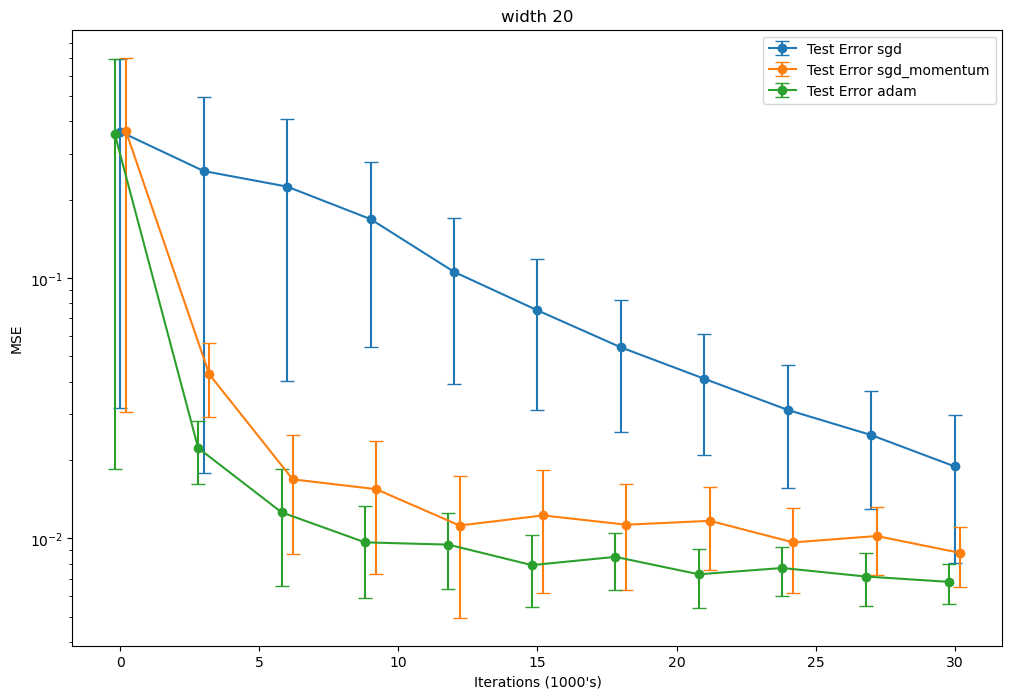

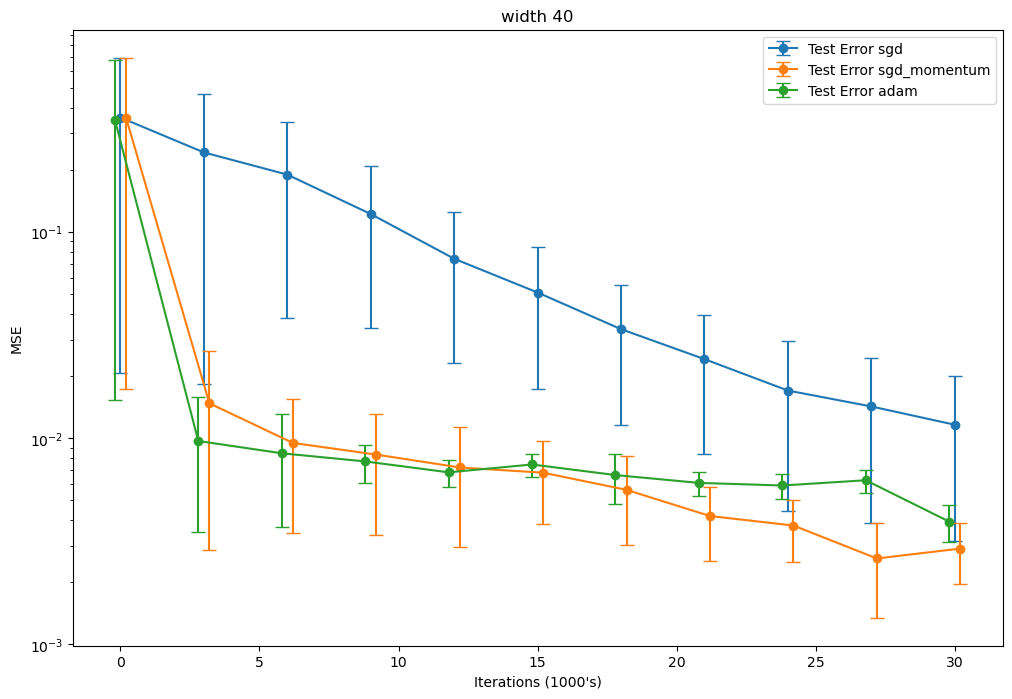

In [23]:
for w in nn_widths:
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, optim in enumerate(nn_optimizer):

        # uncomment below if you ran the previous block to train all models
        # list_of_history = [nets_by_size[s][w][optim]['hist_all'] for s in nn_seeds]
        
        # uncomment below if you want to use pretrained weights
        c = get_ckpt_dir(optim)
        list_of_history = [
            torch.load(
                os.path.join(f'{get_ckpt_dir(optim)}/width{w}/seed{s}', 'ckpt_and_history.pt')
            ) for s in nn_seeds
        ]
        plot_with_error_bar(list_of_history, optim=optim, plot_test=True, idx=i, ax=ax)  
    ax.set_title(f"width {w}")
    plt.show()

## Visualize ReLU elbow positions

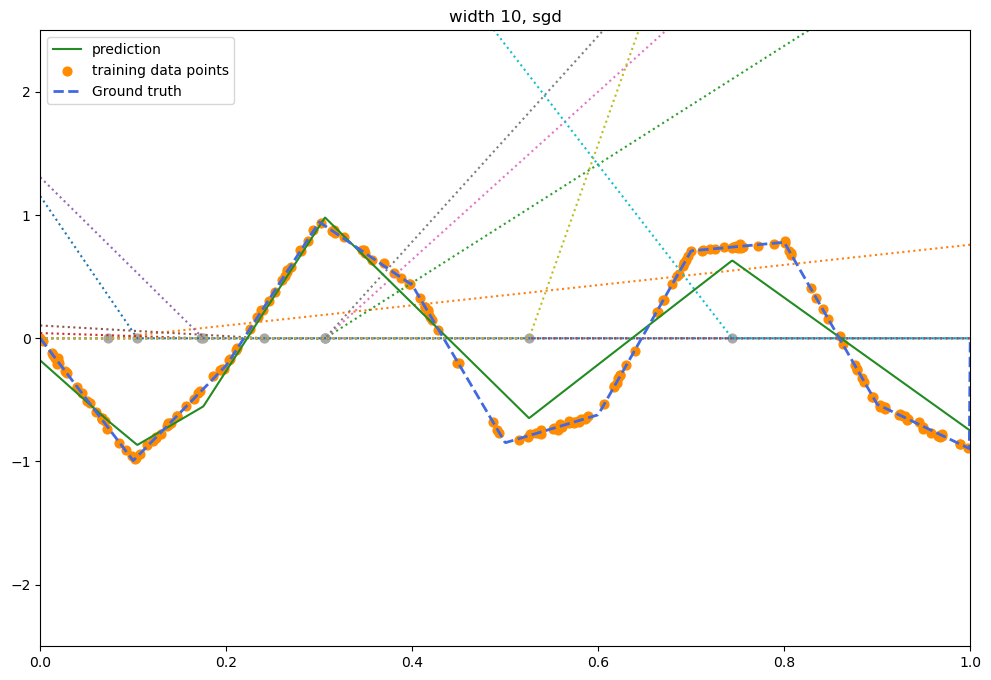

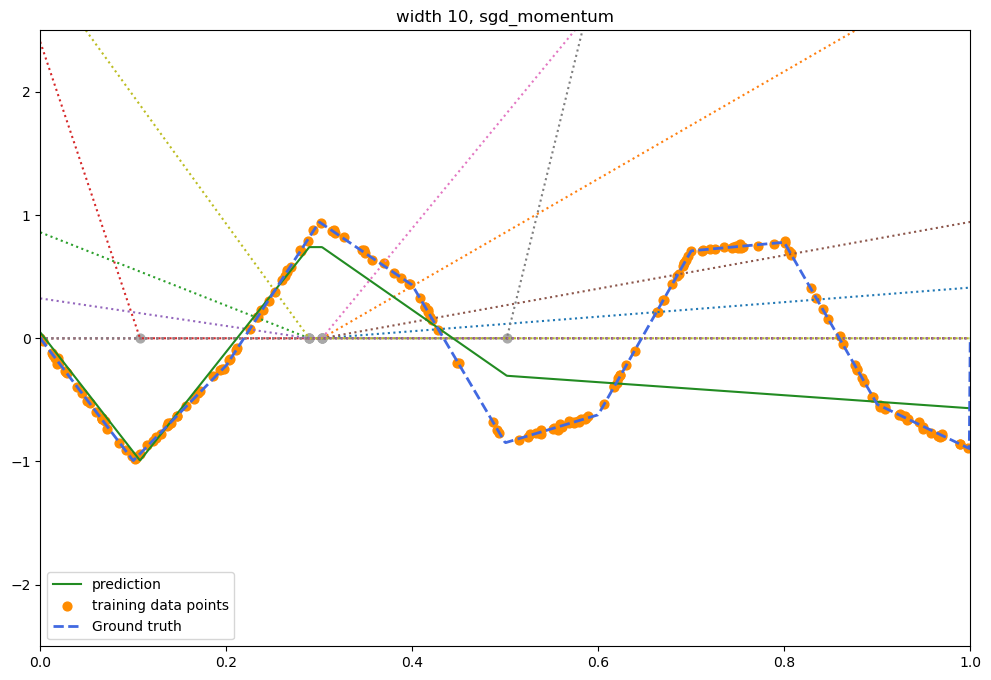

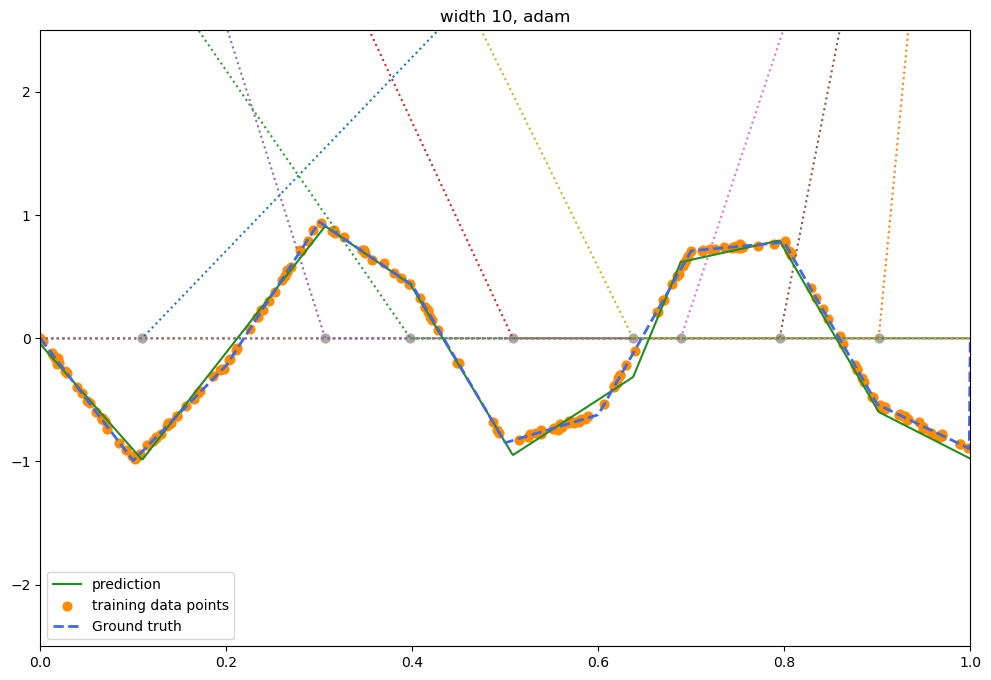

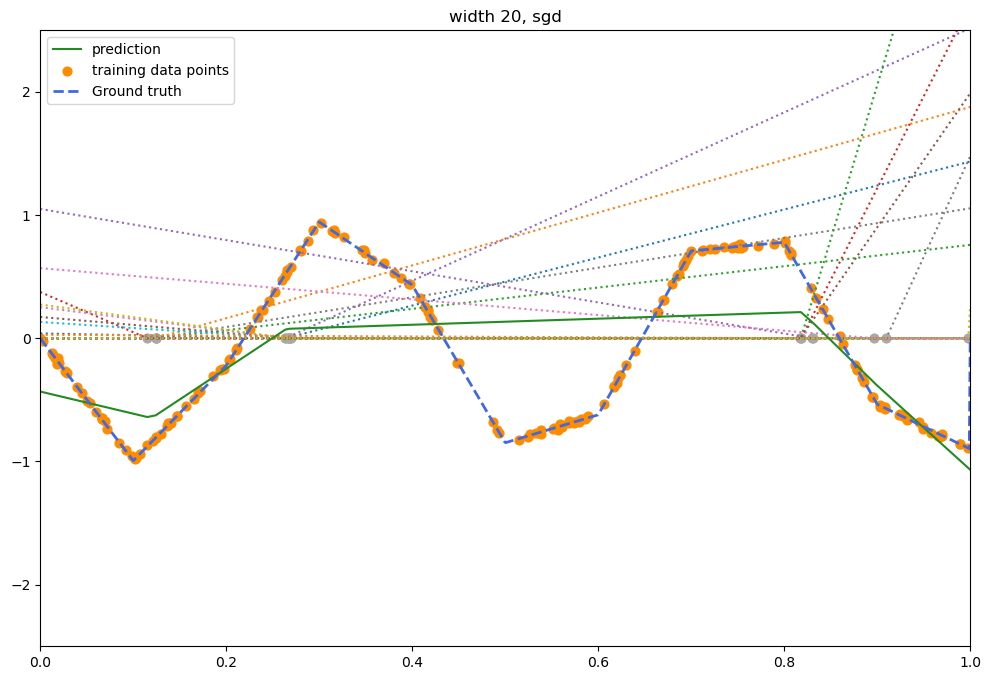

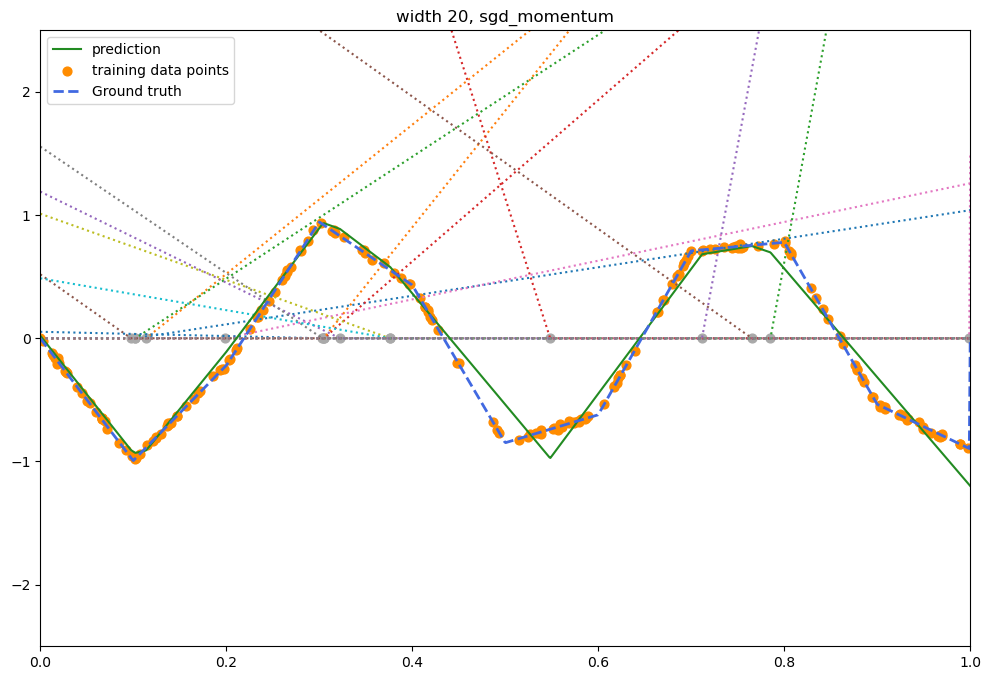

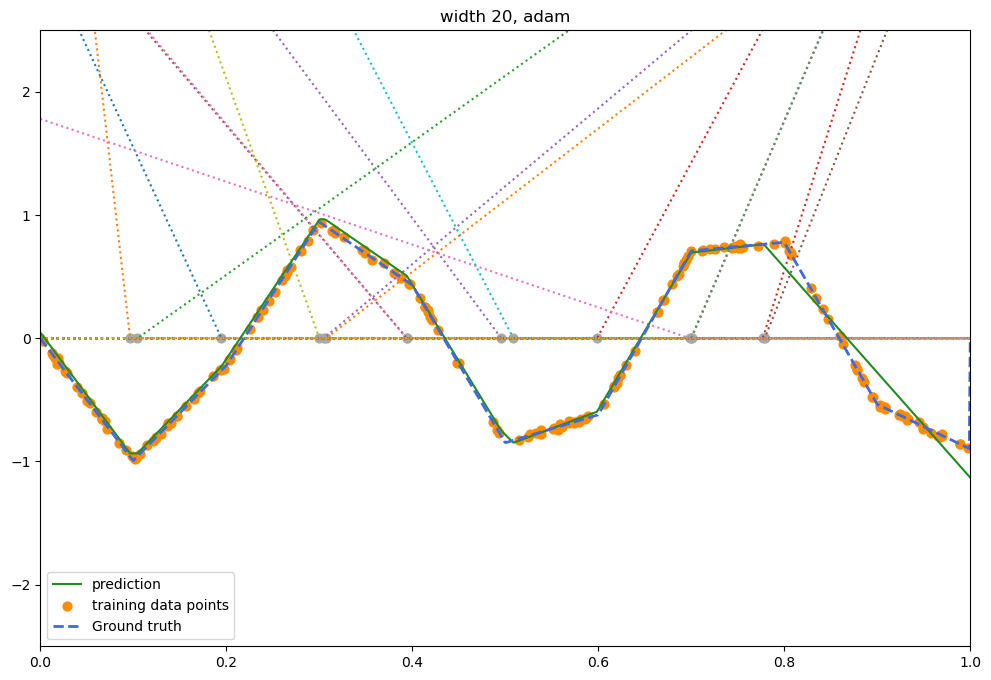

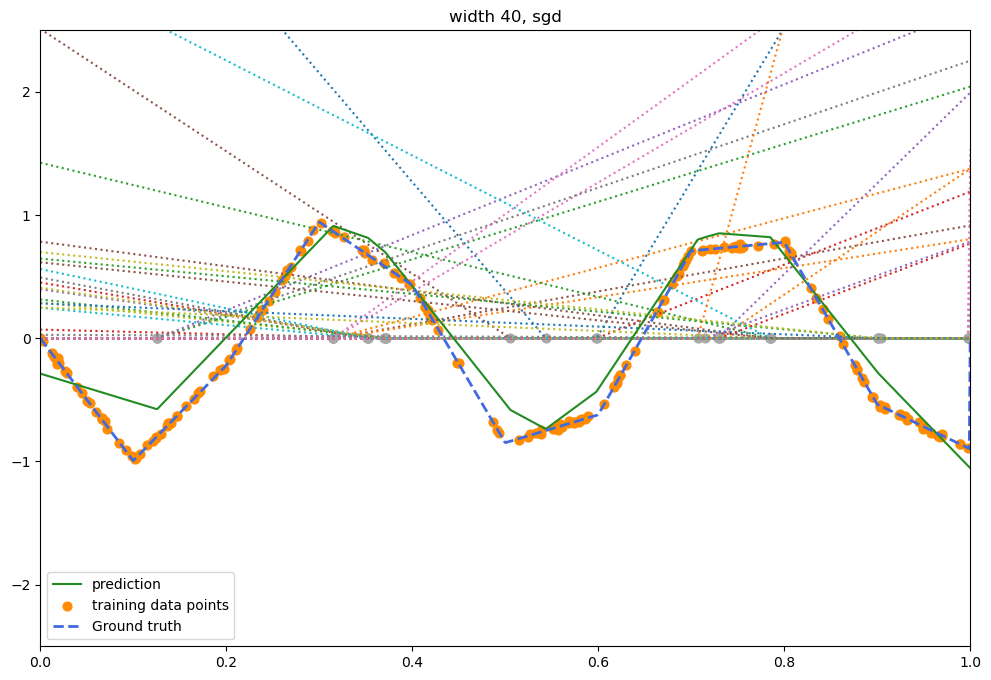

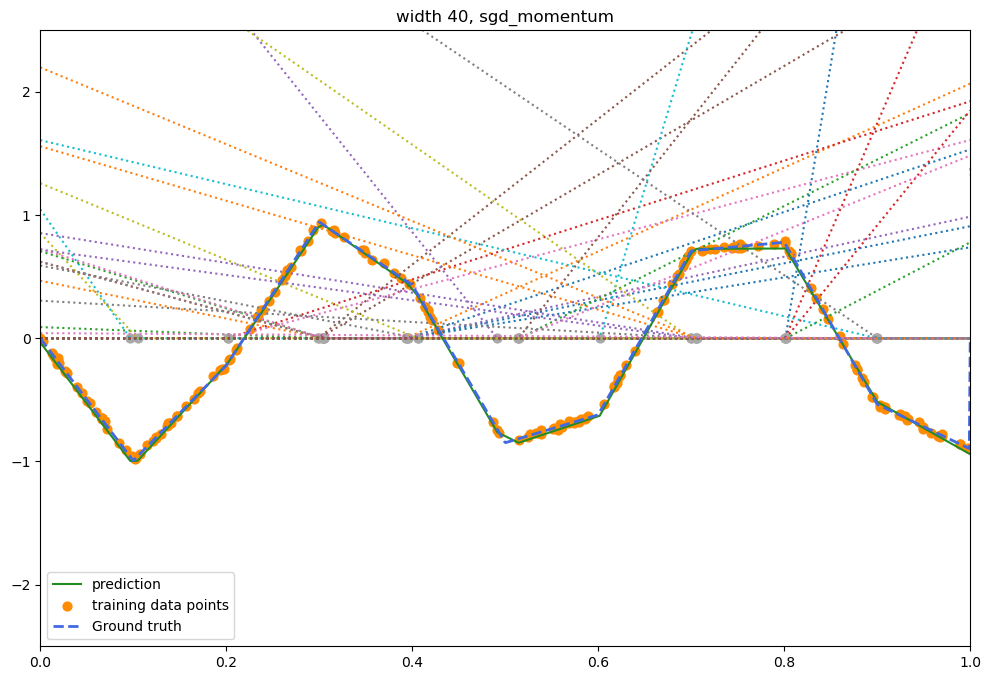

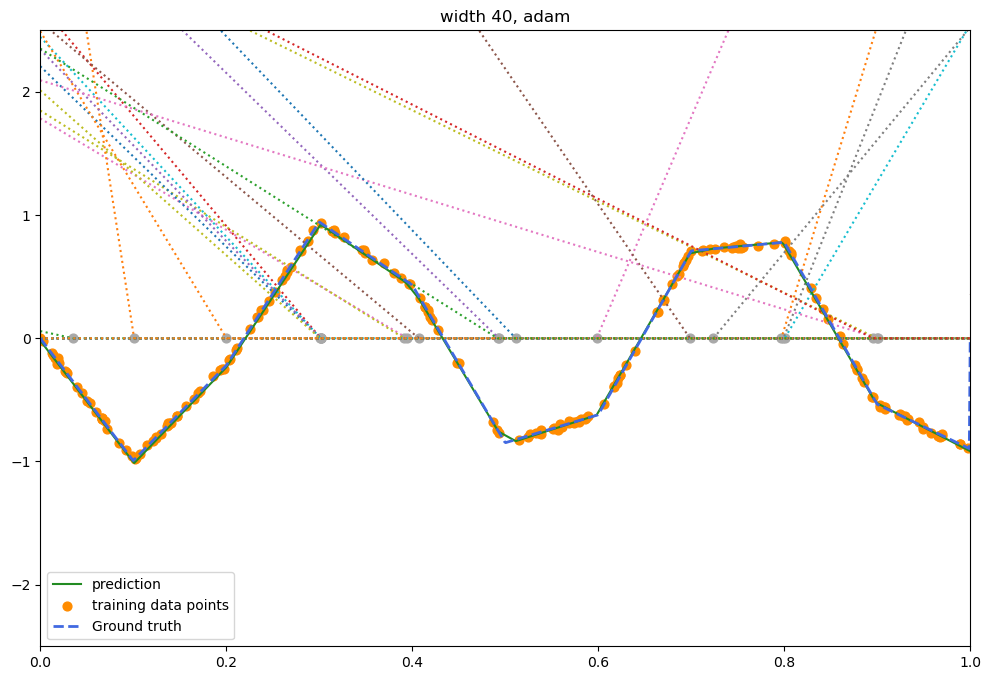

In [35]:
SAMPLE = nn_seeds[0]
for w in nn_widths:
    for optim in nn_optimizer:
        fig, ax = plt.subplots(figsize=(12, 8))
        net = nets_by_size[SAMPLE][w][optim]['net']
        plot_update(X, y, X_test, y_test, net, optim=optim, ax=ax)
        ax.set_title(f"width {w}, {optim}")
        plt.show()

## Questions

Questions to consider while exploring the training process for all layer weights with different optimizers:
- **How does the hidden layer width and different optimizers impact the learned function and test error?**

- **What happens to the elbow locations using different optimizers during training?**
- **Check out `helper.py` file. Are the circle dots on the graphs above mean or median? Why not plot the other one?**

-  **How are error bars computed? Are the upper and lower marks maximum/minimum, standard deviation or something else? Does it make sense to plot standard deviation here?**

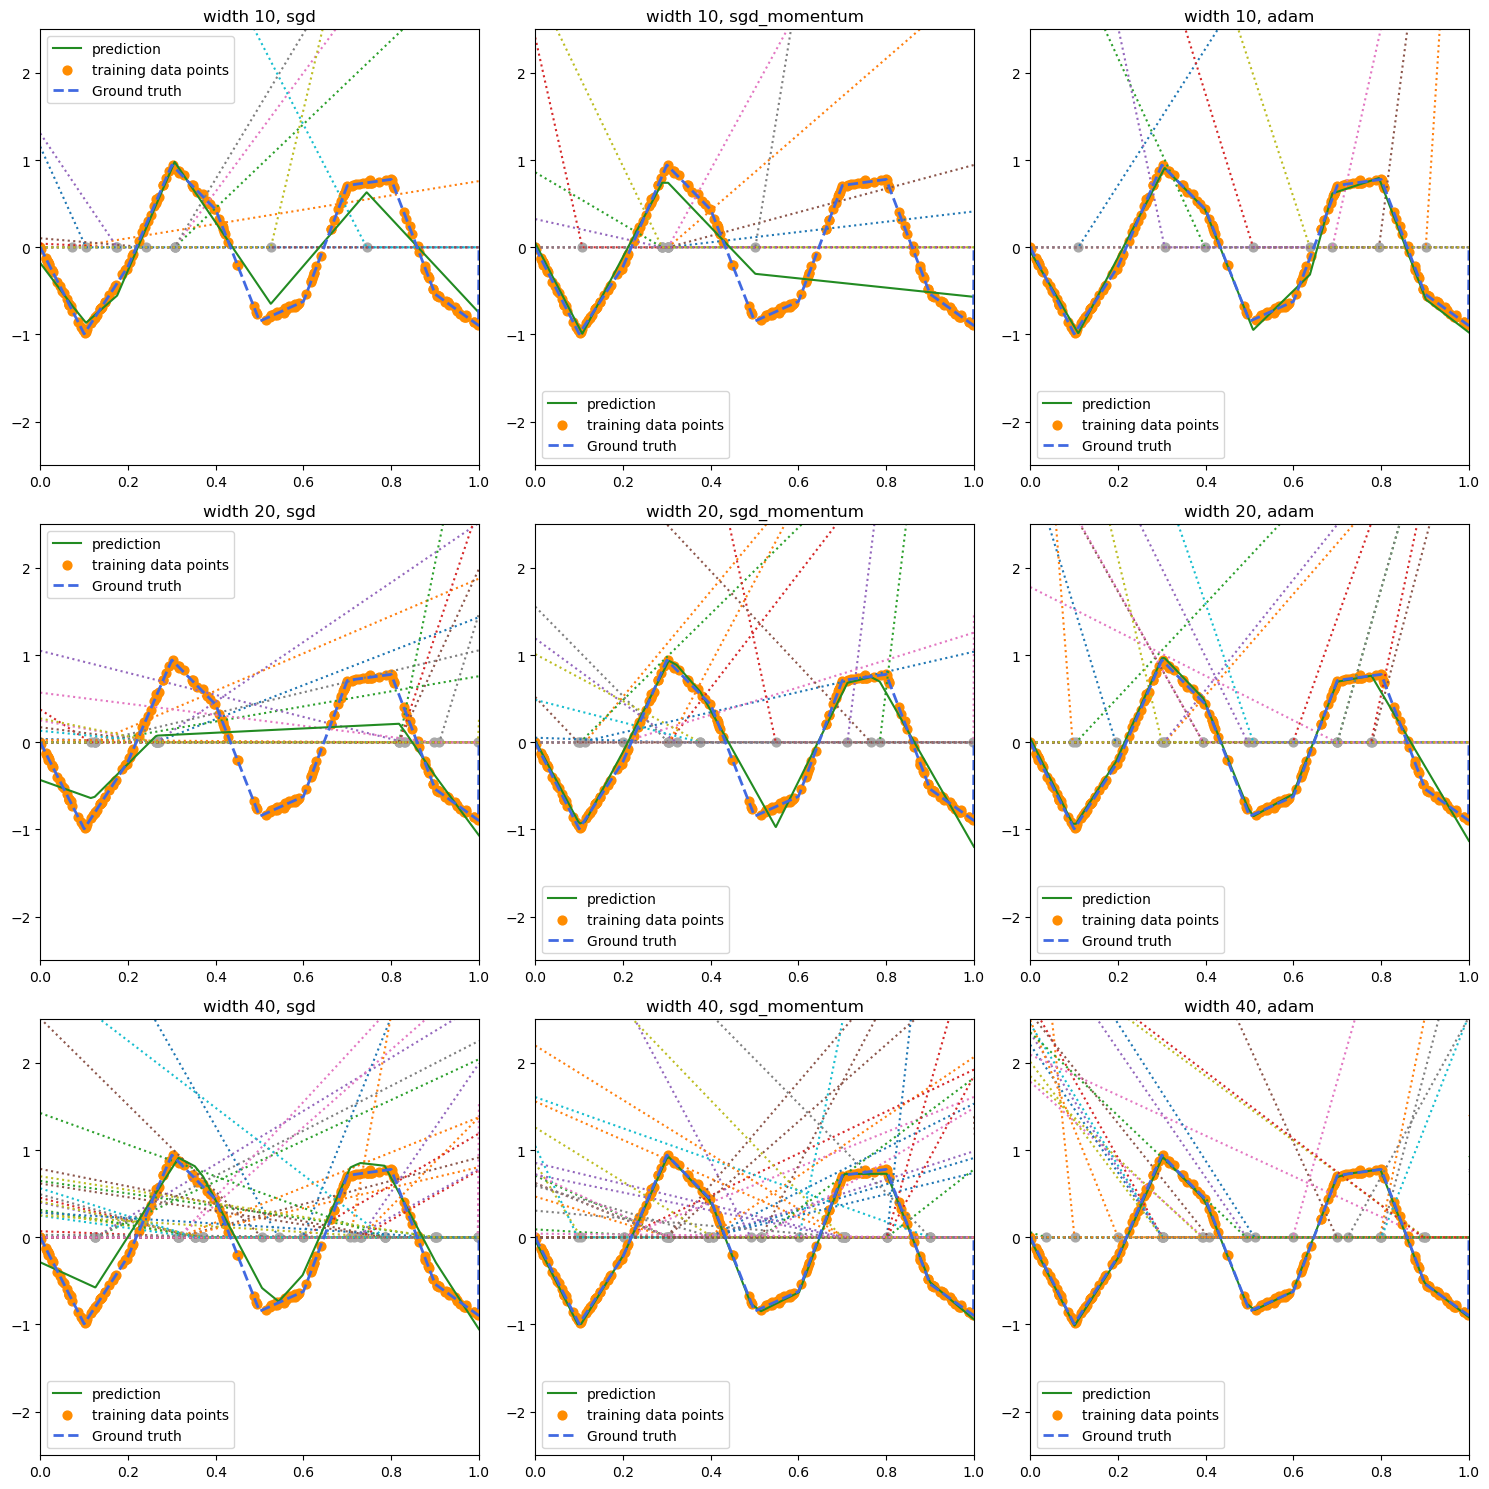

In [34]:
# Create a single figure with a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axs array for easy indexing
axs = axs.ravel()

# Iterate through the widths and optimizers and plot in subplots
for i, w in enumerate(nn_widths):
    for j, optim in enumerate(nn_optimizer):
        ax = axs[i * 3 + j]
        net = nets_by_size[SAMPLE][w][optim]['net']
        plot_update(X, y, X_test, y_test, net, optim=optim, ax=ax)
        ax.set_title(f"width {w}, {optim}")

# Adjust subplot layout
plt.tight_layout()
plt.show()
